# AAI614: Data Science & its Applications
## Student Name: Farah Malaeb

*Project-Skeleton: DAnalyzing Skiils from Job Postings*

<a href="https://colab.research.google.com/github/harmanani/AAI614/blob/main/Week%207/Project-Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# We'll begin by loading all the HTML files in the `job_postings` directory.
# Loading HTML files**

import glob
html_contents = []

for file_name in sorted(glob.glob('job_postings/*.html')):
    with open(file_name, 'r') as f:
        html_contents.append(f.read())
        
print(f"We've loaded {len(html_contents)} HTML files.")

We've loaded 1458 HTML files.


We've loaded 1458 HTML files into `html_contents`. Each HTML file can be parsed using Beautiful Soup. 

**Parsing HTML files**

In [2]:
#FIXME by adding the necessary import for the below code to work
from bs4 import BeautifulSoup #FIXME

soup_objects = []
for html in html_contents:
    soup = BeautifulSoup(html , 'html.parser')#FIXME
    assert soup.title is not None
    assert soup.body is not None
    soup_objects.append(soup)

Each parsed HTML file contains a title and a body.  Are there any duplicates across the titles or bodies of these files? We can find out by using Pandas.

**Checking title and body texts for duplicates**

In [3]:
import pandas as pd
html_dict = {'Title': [], 'Body': []}

for soup in soup_objects:
    title = soup.find('title').text
    # Add the necessary code to extract the body from an HTML code
    body = soup.find('body').text if soup.find('body') else ''#FIXME
    html_dict['Title'].append(title)
    html_dict['Body'].append(body)
    
df_jobs = pd.DataFrame(html_dict)
summary = df_jobs.describe()
print(summary) 

                                Title  \
count                            1458   
unique                           1364   
top     Data Scientist - New York, NY   
freq                               13   

                                                     Body  
count                                                1458  
unique                                               1458  
top     Data Scientist - Beavercreek, OH\nData Scienti...  
freq                                                    1  


#### Based on the output we can see that there are 1458 titles are present in the dataset. And 1364 out of 1458 are unique
#### The most frequently occurring title is "Data Scientist - New York, NY." which has a frequency of 13.

#### And 1458 bodies are present, meaning each HTML file has a corresponding body. And all of them are unique. And since  all bodies are unique, the most common body appears only once the freq is 1.

We’ve confirmed that no duplicates are present within the html. Now, lets explore the HTML content in more detail. The goal of our exploration will be to determine how job-skills are described in the HTML.

### Exploring the HTML for Skill Descriptions

We’ll start our exploration by rendering the HTML at index of 0 of `html_contents`.

**Rendering the HTML of the first job-posting**

In [4]:
from IPython.display import display, HTML
display(HTML(html_contents[0]))


#### This output means that the first job posting in html_contents[0] is "Data Scientist - Beavercreek, OH" and its  structured into two main parts "Job Summary" and "Skills or Qualifications"

We can subdivide `html_contents[0]` into 2 conceptually-different parts:

.. An initial job summary.
.. A list of bulleted skills required to get the job.

Is the next job posting structured in a similar manner? Lets find out, by rendering `html_contents[1]`.

**Listing 17. 5. Rendering the HTML of the second job-posting**

In [5]:
display(HTML(html_contents[1]))

The bullet-points in `html_contents[0]` and `html_contents[1]` serve a singular purpose. They offer us brief, sentence-length descriptions of unique skills required for each position.

Do these types of bulleted skill descriptions appear in other job posts? We’ll now find out. First, we’ll extract the bullets from each of our parsed html files. 

**Listing 17. 6. Extracting bullets from the HTML**

In [6]:
df_jobs['Bullets'] = [[bullet.text.strip() 
                      for bullet in soup.find_all('li')]
                      for soup in soup_objects]

df_jobs.shape[0]

1458

#### The corresponding output means that the DataFrame contains 1458 rows (one for each job posting)

What percentage of job postings actually contain bulleted text? We need to find out! If that percentage is too low, then further bullet-analysis is not worth our time.

**Measuring the percent of bulleted postings**

In [7]:
bulleted_post_count = 0
for bullet_list in df_jobs.Bullets:
    if bullet_list:
        bulleted_post_count += 1
          
percent_bulleted = 100 * bulleted_post_count / df_jobs.shape[0]
print(f"{percent_bulleted:.2f}% of the postings contain bullets")

90.53% of the postings contain bullets


#### The output indicates that the majority of job postings (around 91%) contain bullet points describing skills or qualifications.

90% of the job postings contain bullets. Do all (or most) of these bullets focus on skills? We better gage the contents of the bullet-points by printing the top-ranked words within their texts. Below, we'll we rank the words using summed TFDIF values. 

**Examining the top-ranked words in the HTML bullet**

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def rank_words(text_list):
    vectorizer = TfidfVectorizer(stop_words = 'english')                         # Add English Stop words
    tfidf_matrix = vectorizer.fit_transform(text_list).toarray()
    df = pd.DataFrame({'Words': vectorizer.get_feature_names_out(),
                       'Summed TFIDF': tfidf_matrix.sum(axis=0)})
    sorted_df = df.sort_values('Summed TFIDF', ascending=False)
    return sorted_df

all_bullets = []
for bullet_list in df_jobs.Bullets:
    all_bullets.extend(bullet_list)

sorted_df = rank_words(all_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
experience    878.030398
      data    842.978780
    skills    440.780236
      work    371.684232
   ability    370.969638


#### The output shows the important words that appear in job posting, having the highest TFIDF scores.

Terms such as _skills_ and _ability_ appear among the top 5 bulleted words. How do these bulleted words compare to the remaining words in each job posting? Lets find out. 

**Examining the top-ranked words in the HTML bodies**

In [9]:
non_bullets = [] #initializing empty list to store job descriptions without bullet points
for soup in soup_objects: # Iterating over all parsed HTML content 
    body = soup.body
    for tag in body.find_all('li'): #finding all <li> tags(bullet points) in the body of the HTML.
        tag.decompose() #Removes these <li> tags entirely from the HTML content.
        
    non_bullets.append(body.text)
    
sorted_df = rank_words(non_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
      data     99.111312
      team     39.175041
      work     38.928948
experience     36.820836
  business     36.140488


#### The output shows the top 5 words in the non-bulleted text after extracting the non-bulleted content from the job postings.

The words _skills_ and _ability_ are no longer present in the ranked output.  Thus, the non-bulleted text appears to be less skill-oriented than the bullet contents.

Strangely, the words _scientist_ and _science_ is missing from the list. Perhaps some posts pertain to data-driven jobs which aren't directly data science jobs? Lets actively explore this possibility. 

**Checking titles for references to data science positions**

In [10]:
regex = r'Data Scien(ce|tist)'
df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]

percent_non_ds = 100 * df_non_ds_jobs.shape[0] / df_jobs.shape[0]
print(f"{percent_non_ds:.2f}% of the job posting titles do not mention a "
       "data science position. Below is a sample of such titles:\n")

for title in df_non_ds_jobs.Title[:10]:
    print(title)

64.33% of the job posting titles do not mention a data science position. Below is a sample of such titles:

Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL
Data Manager / Analyst - Oakland, CA
Scientific Programmer - Berkeley, CA
JD Digits - AI Lab Research Intern - Mountain View, CA
Operations and Technology Summer 2020 Internship-West Coast - Universal City, CA
Data and Reporting Analyst - Olympia, WA 98501
Senior Manager Advanced Analytics - Walmart Media Group - San Bruno, CA
Data Specialist, Product Support Operations - Sunnyvale, CA
Deep Learning Engineer - Westlake, TX
Research Intern, 2020 - San Francisco, CA 94105


/var/folders/mt/xp_8npgn0q93wgxqljbfdk0r0000gn/T/ipykernel_3469/2465209268.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]


#### The output shows 64.33% job posting titles do not explicitly mention "Data Science" or "Data Scientist." And it shows some job posting examples that are not related to Data Science or Data Scientist.

Theirst posting on the list is for a _Patient Care Assistant_ or _PCA_. The erroneous posting contains skills that we both lack and also have no interest in obtaining.

**Sampling bullets from a non-data science job**

In [11]:
bullets = df_non_ds_jobs.Bullets.iloc[0]
for i, bullet in enumerate(bullets[:5]):
     print(f"{i}: {bullet.strip()}")

0: Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse
1: Accurately documents care provided
2: Applies safety principles and proper body mechanics to the performance of specific techniques of personal and supportive care, such as ambulation of patients, transferring patients, assisting with normal range of motions and positioning
3: Participates in economical utilization of supplies and ensures that equipment and nursing units are maintained in a clean, safe manner
4: Routinely follows and adheres to all policies and procedures


#### The output lists the first five bullet points from the job posting, prefixed with their indices.
#### This approach is helpful for quickly inspecting the bullet-pointed skills or job requirements in a specific job posting.

We need to leverage text similarity in order to filter out those jobs that do not align with our resume content. 
Lets proceed to filter the jobs by relevance.

## Filtering Jobs by Relevance

Our goal is to evaluate job relevance using text similarity. We'll want to compare the text within each posting to our resume and/or book table-of-contents. In preparation, lets now store our resume within a `resume` string.

**Loading the resume**

In [12]:
resume = open('resume.txt', 'r').read()
print(resume)

Experience

1. Developed probability simulations using NumPy.
2. Assessed online ad-clicks for statistical significance using Permutation testing.
3. Analyzed disease outbreaks using common clustering algorithms.

Additional Skills

1. Data visualization using Matplotlib.
2. Statistical analysis using SciPy.
3. Processing structured tables using Pandas.
4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.
5. Extracting locations from text using GeonamesCache.
6. Location analysis and visualization using GeonamesCache and Basemap.
7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.
8. NLP analysis and text topic detection using Scikit-Learn.


#### This code cell analyze the text similarity between a resume and the job resume to determine relevance.
#### This approach allows automated filtering of job postings by relevance to your skills and experience, making the job search more efficient

In this same manner, we can store the table of contents within a `table_of_contents` string.

**Loading the table-of-content**

In [13]:
desired = open('desired_skills.txt', 'r').read()

Together, `resume` and `table_of_contents` summarize our existing skill-set. Lets concatenate these skills into a single `existing_skills` string.

**Combining skills into a single string**

In [14]:
existing_skills = resume + desired

We want to compute all similarities between `df_jobs.Body` and `existing_skills.` This computation first requires that we vectorize all texts. 

**Vectorizing our skills and the job-posting data**

In [15]:
text_list = df_jobs.Body.values.tolist() + [existing_skills]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_list).toarray() #Processes text_list to generate the TF-IDF matrix 
#for all the text entries, including the job descriptions and existing_skills.

Our vectorized texts are stored in a matrix format within `tfidf_matrix`. The final matrix row (`tfidf_matrix[-1]`) corresponds to our existing skill-set. Thus, we can easily compute the cosine similarities between the job postings and `existing_skills`, by running `tfdf_matrix[:-1] @ tfidf_matrix[-1]`. 

**Computing skill-based cosine similarities**

In [16]:
cosine_similarities = tfidf_matrix[:-1] @ tfidf_matrix[-1]

We can leverage `cosine_similarities` to rank to the jobs by relevance. Lets proceed to carry out the ranking. Afterwards, we'll confirm if the 20 least-relevant jobs have anything to do with data science.

**Printing the 20 least-relevant jobs**

In [17]:
df_jobs['Relevance'] = cosine_similarities
sorted_df_jobs = df_jobs.sort_values('Relevance', ascending=False)
for title in sorted_df_jobs[-20:].Title:
    print(title)

Software Developer–Natural Language Processing - Champaign, IL
Project Evaluator - San Francisco, CA 94111
Configuration Management Specialist - Dahlgren, VA
Certified Strength and Conditioning Specialist - United States
Real Estate Development Manager - Southern California - Corona, CA
QSR Store Assistant - Pleasanton, TX
QSR Store Assistant - Jacksonville, FL 32226
Part-time instructor of Statistics for Data Science and Machine Learning - San Francisco, CA 94105
Professor of Data Sciences and Operations (Open Rank)-Statistics - Los Angeles, CA
iQ Science Representative - Berkeley, CA
Manager, Valuation and Litigation Services - Chicago, IL
Entry Level Accenture Consulting Development Program Analyst - San Francisco, CA 94105
Director of Marketing - Cambridge, MA
Dev Ops Engineer AWS - Rockville, MD
Plant Engineering Specialist - San Pablo, CA
Web Development Teaching Assistant - UC Berkeley (Berkeley) - Berkeley, CA
Web Development Teaching Assistant - UC Berkeley (Berkeley) - Full T

Almost all the printed jobs are completely irrelevant! Now, for comparison’s sake, lets print the 20 most-relevant job titles in `sorted_ds_jobs`.

**Printing the 20 most-relevant jobs**

In [18]:
for title in sorted_df_jobs[:20].Title:
    print(title)

Chief Data Officer - Culver City, CA 90230
Data Scientist - San Diego, CA
Data Scientist - Beavercreek, OH
Data Scientist - Streetsboro, OH 44241
Data Scientist - Beavercreek, OH
Senior Data Scientist - New York, NY 10018
Data Scientist - Birmingham, AL 35233
Data Architect - Raleigh, NC 27609
Data Scientist (PhD) - Spring, TX
Data Science Analyst - Chicago, IL 60612
Associate Data Scientist (BS / MS) - Spring, TX
Data Scientist - Los Angeles, CA
Sr Director of Data Science - Elkridge, MD
Sr Data Scientist. - Alpharetta, GA 30004
Data Scientist - New York, NY 10011
Product Engineer – Spatial Data Science and Statistical Analysis - Redlands, CA
Data Modeler - Melbourne, FL
Data Scientist (PhD) - Intern - Spring, TX
Senior Data Scientist - New York, NY 10038
Data Scientist - Remote


Whenv`df_jobs.Relevance` is high, the associated job postings are relevant. As `df_jobs.Relevance` decreases, the associated jobs become less relevant. Thus, we can presume that there exists some `df_jobs.Relevance` cutoff, which separates the relevant jobs from the non-relevant jobs. Lets try to identify that cutoff. by visualizing the shape of the sorted relevance distribution.

**Plotting job-ranking vs relevance**

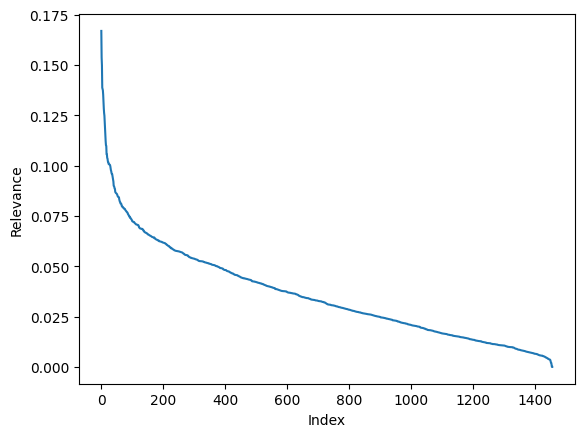

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.show()

Our relevance curve resembles a K-means Elbow plot. Initially, the relevance drops rapidly. Then, at an x-value of approximately 60, the curve begins to level off. Lets emphasize this transition by striking a vertical line through the x-position of 60 in our plot.

**Adding a cutoff to the relevance plot**

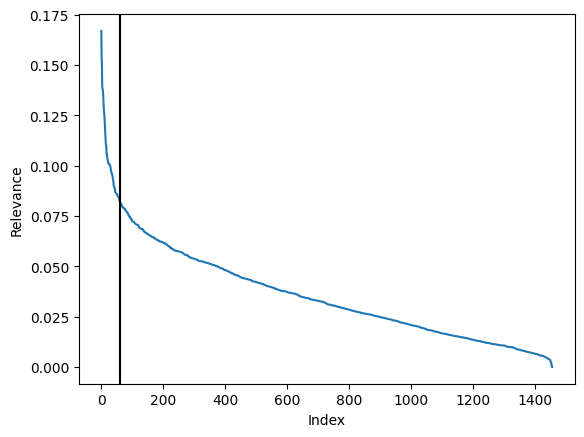

In [20]:
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.axvline(60, c='k')
plt.show()

Our plot implies that the first 60 jobs are noticeably more relevant than all subsequent jobs. Based on our hypothesis, jobs 40 - 60 should be highly relevant.

**Printing jobs below the relevance cutoff**

In [21]:
for title in sorted_df_jobs[40: 60].Title.values:
    print(title)

Data Scientist (Mathematical and Statistical Sciences) - Charlottesville, VA 22903
Data Scientist (SAS / R Programmer - Data Mining) - San Diego, CA
Data Scientist III - Pasadena, CA 91101
Data Science & Tagging Analyst - Bethesda, MD 20814
Data Scientist and Visualization Specialist - Santa Clara Valley, CA 95014
Data Scientist - Seattle, WA
Data Scientist - Digital Factory - Tampa, FL 33607
Data Scientist - Bioinformatics - Denver, CO 80221
SWE Data Scientist - Santa Clara Valley, CA 95014
Data Scientist - Los Angeles, CA 90017
Internship - Data Scientist, Denver CO (Summer 2020) - Denver, CO 80221
Data Scientist - Seattle, WA
Research Associate - Data Science - Washington, DC
Data Scientist - Portsmouth, NH
Data Scientist - United States
2020 Intern - Data Scientist - United States
Data Scientist - Sunnyvale, CA 94089
NASA SMAEC Data Scientist - Houston, TX
Data Science Software Engineer - San Diego, CA 92130
Data Scientist - Baltimore, MD


#### The code displays 20 job titles ranked by relevance from positions 40 to 60 in the sorted list. Almost all titles explicitly include "Data Scientist," which matches the skillset defined in the resume and desired skills.


Almost all the printed jobs are are highly relevant. Implicity, the relevance should decrease when we print the next 20 job-titles, since they lie beyond the bounds of index 60. Lets verify if this is the case.

**Printing jobs beyond the relevance cutoff**

In [22]:
for title in sorted_df_jobs[60: 80].Title.values:
    print(title)

Global Data Engineer - Boston, MA
Data Engineer - Seattle, WA
2020 Intern - Senior Data Scientist - United States
Data Analytics and Insights Specialist - Montvale, NJ 07645
Data Scientist - Product BURLINGAME, CALIFORNIADATA AND MACHINE LEARNINGFULL-TIME - Burlingame, CA 94010
Senior Data Analyst - Los Angeles, CA
Analytics, Retail Marketing Analyst - Woonsocket, RI
Data Scientist - Denver, CO 80221
Data Scientist I - Bend, OR 97701
IT Data Scientist - Contract - Riverton, UT
Data Scientist - Pasadena, CA 91107
Data Scientist / ML Engineer - Los Altos, CA
Full Time Opportunities for Students or Recent Graduates: Data & Applied Sciences - Redmond, WA
Data Scientist - Grapevine, TX 76051
Full Time Opportunities for PhD Students or Recent Graduates: Data & Applied Sciences - Redmond, WA
Data Scientist - United States
Internship Opportunities for Students: Data & Applied Sciences - Redmond, WA
Internship Opportunities for PhD Students: Data & Applied Sciences - Redmond, WA
Data Scientist 

#### These are job postings (ranks 60 to 80 by relevance) reflects a continued focus on data science-related positions, with some variation in titles and roles.

A majority of the printed jobs refer to data science / analyst roles, outside the scope of health science or management. We can quickly quantify this observation using regular expressions. Below, we’ll define a `percent_relevant_tiles` function, which returns the percent of non-management data science and analysis jobs within a data frame slice.

**Measuring title relevance in a subset of jobs**

In [23]:
import re
def percent_relevant_titles(df):
    regex_relevant = re.compile(r'Data (Scien|Analy)',
                                flags=re.IGNORECASE)
    regex_irrelevant = re.compile(r'\b(Manage)',
                                  flags=re.IGNORECASE)
    match_count = len([title for title in df.Title
                       if regex_relevant.search(title)
                       and not regex_irrelevant.search(title)])
    percent = 100 * match_count / df.shape[0]
    return percent

percent = percent_relevant_titles(sorted_df_jobs[60: 80])
print(f"Approximately {percent:.2f}% of job titles between indices "
       "60 - 80 are relevant")

Approximately 65.00% of job titles between indices 60 - 80 are relevant


Approximately 65% of the job-titles in `sorted_df_jobs[60: 80]` are relevant. Perhaps that percentage will drop if we sample the next 20 jobs, across an index range of 80 - 100. 

**Measuring title relevance in the next subset of jobs**

In [24]:
percent = percent_relevant_titles(sorted_df_jobs[80: 100])
print(f"Approximately {percent:.2f}% of job titles between indices "
       "80 - 100 are relevant")

Approximately 85.00% of job titles between indices 80 - 100 are relevant


Nope! The data science title-percentage rose to 80%. At what point will the percentage drop below 50%? We can easily find out, using a plot.

**Plotting percent relevance across all title samples**

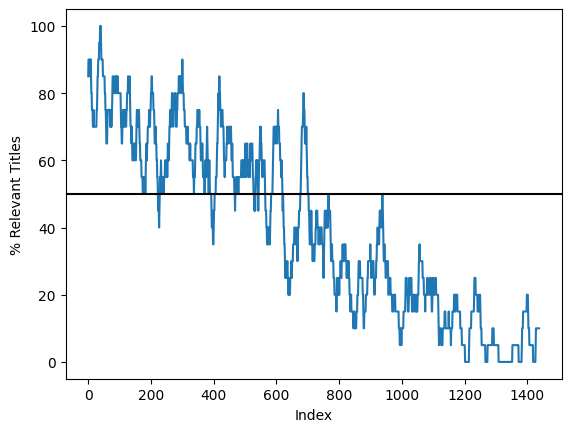

In [25]:
import matplotlib.pyplot as plt
def relevant_title_plot(index_range=20): 
    percentages = []
    start_indices = range(df_jobs.shape[0] - index_range) 
    for i in start_indices:
        df_slice = sorted_df_jobs[i: i + index_range]
        percent = percent_relevant_titles(df_slice)
        percentages.append(percent)

    plt.plot(start_indices, percentages)
    plt.axhline(50, c='k')
    plt.xlabel('Index')
    plt.ylabel('% Relevant Titles')

relevant_title_plot()
plt.show()

The relevant Data Science titles drop below 50% at an index of around 700. Of course, its possible that the cutoff of 700 is merely an artifact of our chosen index range. Will the cutoff still be present if double our index range? Lets find out.

**Plotting percent relevance across an increased index-range**

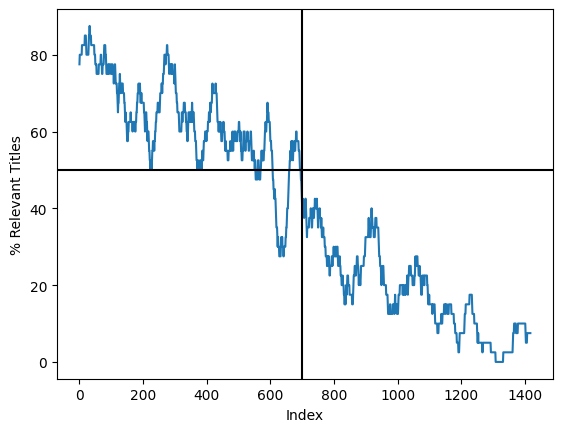

In [26]:
relevant_title_plot(index_range=40)
plt.axvline(700, c='k')
plt.show()

Our updated plot continues to drop below 50% at an index cutoff of 700.


At this point, we face a choice between 2 relevance cutoffs. Our first cutoff, at index 60, is highly precise. Meanwhile, our second cutoff of 700 captures many-more data science positions. So, which cutoff do we choose?  How about we try both cutoffs? That way compare the tradeoffs and benefits of each! 

We will now proceed to cluster the skills within the relevant job postings. Initially, we’ll set our relevance cutoff to an index of 60. 

## Clustering Skills in Relevant Job Postings

Our aim is to cluster the skills within the 60 most-relevant job postings. The skills within each posting are diverse, and partially represented by bullet-points. Consequently, we’ll proceed to cluster the scraped bullets. We’ll start by storing `sorted_df_jobs[:60].Bullets` within a single list.

**Obtaining bullets from the 60 most-relevant jobs**

In [27]:
total_bullets = []
for bullets in sorted_df_jobs[:60].Bullets:
    total_bullets.extend(bullets)

How many bullets are present in the list? Also, are any of the bullets duplicated? We can check using Pandas.

**Summarizing basic bullet statistic**

In [28]:
df_bullets = pd.DataFrame({'Bullet': total_bullets})
print(df_bullets.describe())

                                                   Bullet
count                                                 982
unique                                                787
top     Knowledge of advanced statistical techniques a...
freq                                                    9


Only 900 of the bullets are unique. Below, we’ll filter empty strings and duplicates from our bullet list. Afterwards, we’ll vectorize the list using a TFIDF vectorizer.

**Removing duplicates and vectorizing the bullets**

In [29]:
total_bullets = sorted(set(total_bullets))
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(total_bullets)
num_rows, num_columns = tfidf_matrix.shape
print(f"Our matrix has {num_rows} rows and {num_columns} columns")

Our matrix has 787 rows and 1933 columns


Our vectorized TFIDF matrix is too large for efficient clustering. Lets dimensionally reduce the matrix using the procedure described in Section Fifteen. 

**Dimensionally reducing the TFIDF matrix**

In [30]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
np.random.seed(0)

def shrink_matrix(tfidf_matrix):
    svd_object = TruncatedSVD(n_components=100)
    shrunk_matrix = svd_object.fit_transform(tfidf_matrix)
    return normalize(shrunk_matrix)

shrunk_norm_matrix = shrink_matrix(tfidf_matrix)

We are nearly ready to cluster our normalized matrix using K-means. However, we’ll first need to estimate K using an Elbow plot.

**Plotting an elbow curve using Mini Batch K-Means**

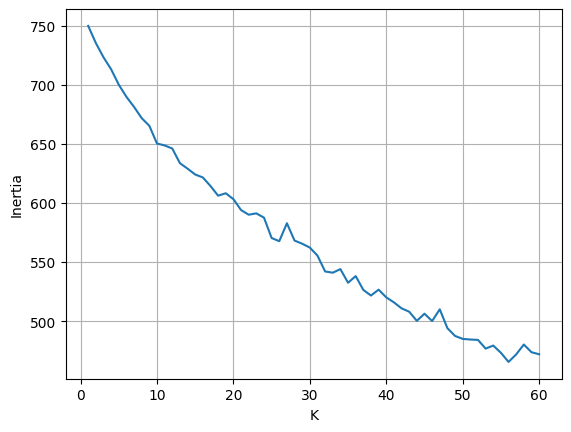

In [31]:
import matplotlib.pyplot as plt
np.random.seed(0)
from sklearn.cluster import MiniBatchKMeans
def generate_elbow_plot(matrix):
    k_values = range(1, 61)
    inertia_values = [MiniBatchKMeans(k).fit(matrix).inertia_
                      for k in k_values]
    plt.plot(k_values, inertia_values)
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

generate_elbow_plot(shrunk_norm_matrix)

The precise location of a bent elbow-shaped transition is difficult to spot. We don't know which K-value to choose. Lets cluster our data multiple times, using K-values of 10, 15, 20, and 25. Afterwards, we’ll compare and contrast the results.

### Grouping the Job Skills into 15 Clusters

Below, we’ll execute K-means using a K of 15. 

**Clustering bullets into 15 clusters**

In [32]:
np.random.seed(0)
from sklearn.cluster import KMeans

def compute_cluster_groups(shrunk_norm_matrix, k=15):
    cluster_model = KMeans(n_clusters=k, random_state=0, n_init='auto')    #Use KMeans to cluster
    clusters = cluster_model.fit_predict(shrunk_norm_matrix)  # predict
    df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters,
                       'Bullet': total_bullets})
    return [df_cluster for  _, df_cluster in df.groupby('Cluster')]

cluster_groups = compute_cluster_groups(shrunk_norm_matrix)

In [34]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


Each of our text clusters is stored as a Pandas table within the `cluster_groups` list. We can visualize the clusters using word clouds. Below, we will define a `cluster_to_image` function, and then apply it to `cluster_groups[0]`.

**Visualizing the first cluster**

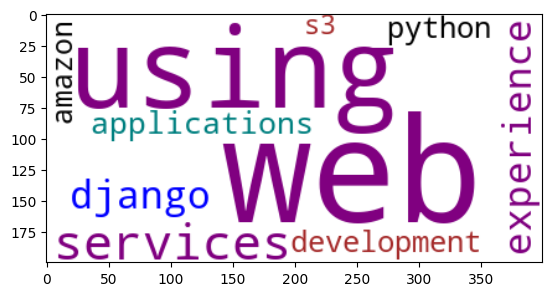

In [35]:
from wordcloud import WordCloud
np.random.seed(0)

def cluster_to_image(df_cluster, max_words=10, tfidf_matrix=tfidf_matrix,
                     vectorizer=vectorizer): 
    indices = df_cluster.Index.values
    summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
    data = {'Word': vectorizer.get_feature_names_out(),'Summed TFIDF': summed_tfidf}
    df_ranked_words = pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)
    words_to_score = {word: score
                     for word, score in df_ranked_words[:max_words].values
                     if score != 0}
    cloud_generator = WordCloud(background_color='white',
                                color_func=_color_func,
                                random_state=1)
    wordcloud_image = cloud_generator.fit_words(words_to_score)
    return wordcloud_image

def _color_func(*args, **kwargs):
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])

wordcloud_image = cluster_to_image(cluster_groups[0])
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.show()

The language in the word-cloud appears to be describing a focused, data-oriented personality. However, that language is a little vague. Perhaps we can learn more about the cluster by printing some sample bullets from `cluster_group[0]`.

**Printing sample bullets from Cluster 0**

In [36]:
np.random.seed(1)
def print_cluster_sample(cluster_id):
    df_cluster = cluster_groups[cluster_id]
    for bullet in np.random.choice(df_cluster.Bullet.values, 5, 
                                   replace=False):
        print(bullet)

print_cluster_sample(0)

Experience using text/web analytics for establishing and expanding keyword searches and using bibliometric analysis tools to perform horizon scans and deep dives into NGIC identified S&T research fields
Excellent proficiency with Django, Flask web application frameworks
Over 5.5 years of experience as python Full Stack Developer with a solid understanding of frontend and backend web development
Developed applications and RESTful web services and API's using PHP, Python/Django, and Zope
Perform text mining and web scraping from online data sources using NLP-relevant packages in Python


Now, lets visualize all 15 clusters using word clouds. 

**Visualizing all 15 clusters**

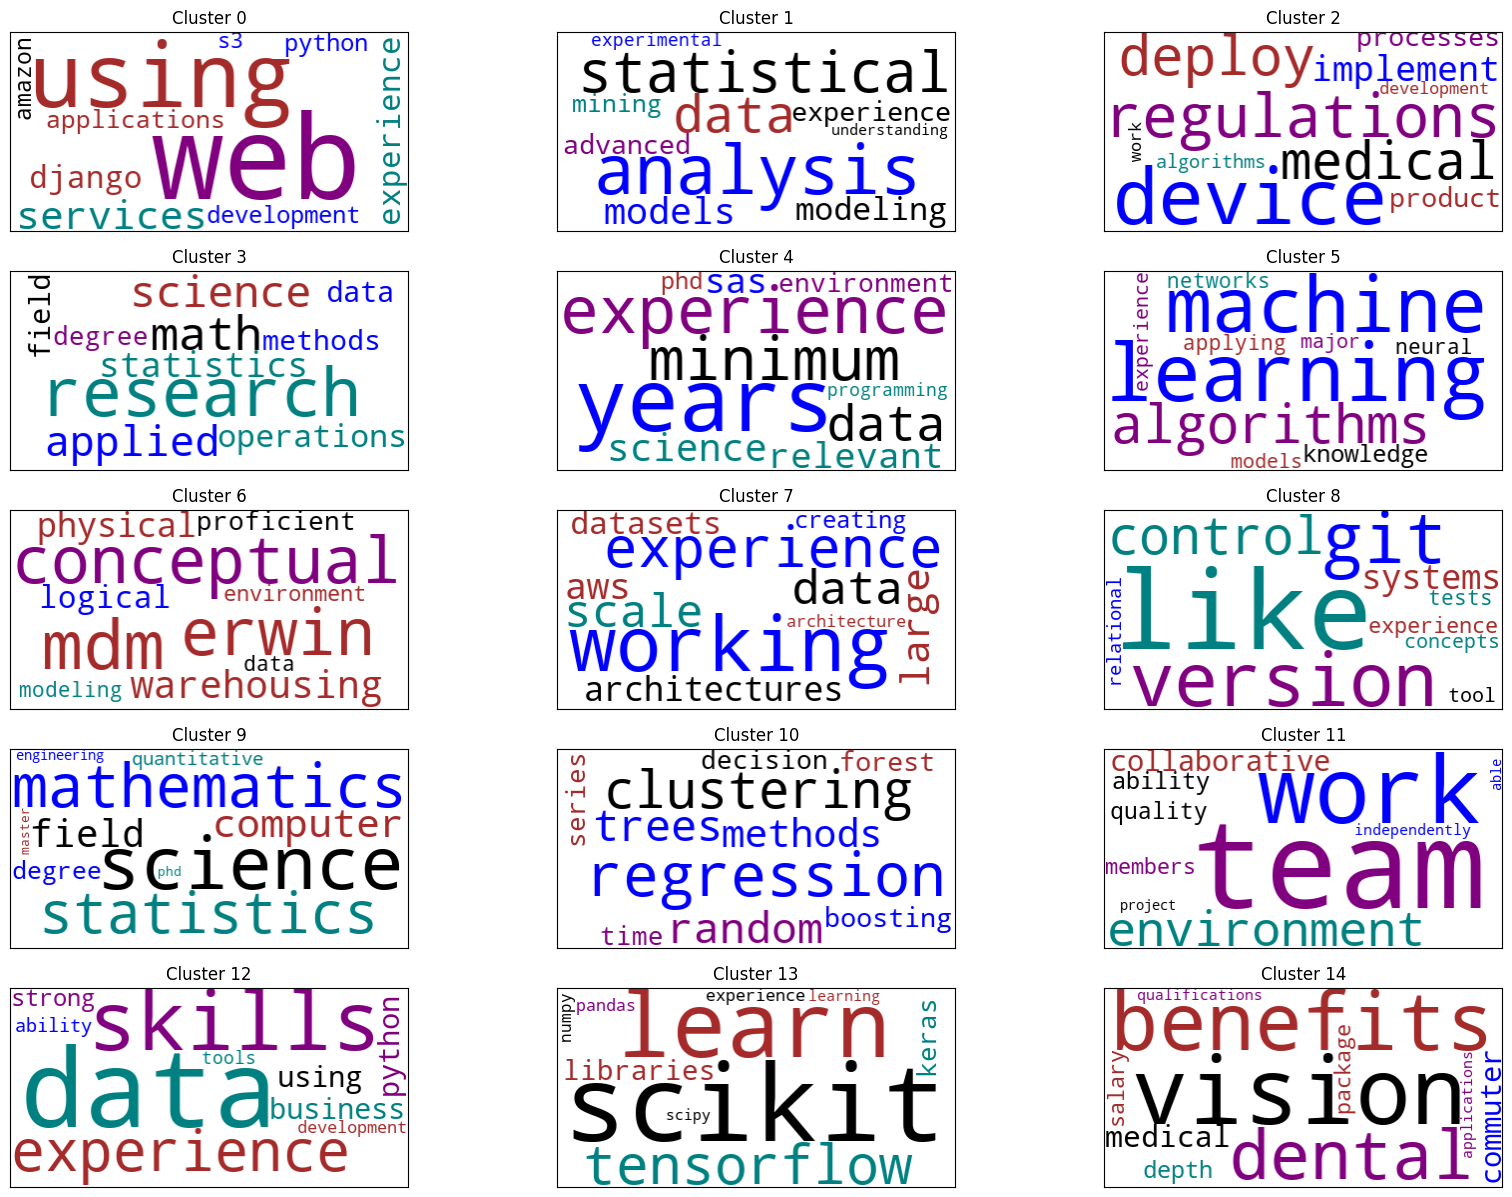

In [37]:
def plot_wordcloud_grid(cluster_groups, num_rows=5, num_columns=3,
                        **kwargs):
    figure, axes = plt.subplots(num_rows, num_columns, figsize=(20, 15))
    cluster_groups_copy = cluster_groups[:]
    for r in range(num_rows):
        for c in range(num_columns):
            if not cluster_groups_copy:
                break
                
            df_cluster = cluster_groups_copy.pop(0)
            wordcloud_image = cluster_to_image(df_cluster, **kwargs)
            ax = axes[r][c]
            ax.imshow(wordcloud_image,
            interpolation="bilinear")   
            ax.set_title(f"Cluster {df_cluster.Cluster.iloc[0]}")
            ax.set_xticks([])
            ax.set_yticks([])

plot_wordcloud_grid(cluster_groups)
plt.show()

Some of the clusters are highly technical. For instance, Cluster 7 fixates on external data science libraries such as Scikit-Learn, Pandas, NumPy, Matplotlib and SciPy. Lets print sample some bullets from Cluster 7, and confirm their focus on DS libraries.

**Printing sample bullets from Cluster 7**

In [38]:
np.random.seed(1)
print_cluster_sample(7)

Working experience in geostatistics, spatial statistics, or other statistical fields involving autocorrelated datasets
Expertise in working with GUI frameworks - PyJamas, Jython
Hands on experience with handling large scale text data
Leading, training and working with other data scientists in designing effective analytical approaches taking into consideration performance and scalability to large datasets
Experience working with multivariate and/or “large” datasets using conventional statistical techniques. Our datasets are typically not large enough to employ machine learning techniques


Meanwhile, other clusters focus on non-technical skills. Perhaps we can separate the technical clusters and soft-skill clusters using text similarity (to our resume). Lets examine this possibility. We’ll start by computing the cosine similarity between each bullet in `total_bullets` and our resume.

**Computing similarities between the bullets and our resume**

In [39]:
def compute_bullet_similarity(bullet_texts):
    bullet_vectorizer = TfidfVectorizer(stop_words='english')
    matrix = bullet_vectorizer.fit_transform(bullet_texts + [resume])
    matrix = matrix.toarray()
    return matrix[:-1] @ matrix[-1]

bullet_cosine_similarities = compute_bullet_similarity(total_bullets)

Our `bullet_cosine_similarities` array contains the text similarities across all clustered bullets. For any given cluster, we can combine these cosine similarities into a single similarity score. According to our hypothesis, a technical cluster should have a higher mean similarity than a soft-skill similarity cluster. Lets confirm if this is the case for the technical Cluster 7 and the soft-skill Cluster 0.

**Comparing mean resume similarities**

In [40]:
def compute_mean_similarity(df_cluster):
    indices = df_cluster.Index.values
    return bullet_cosine_similarities[indices].mean()

tech_mean = compute_mean_similarity(cluster_groups[7])
soft_mean =  compute_mean_similarity(cluster_groups[0])
print(f"Technical cluster 7 has a mean similarity of {tech_mean:.3f}")
print(f"Soft-skill cluster 3 has a mean similarity of {soft_mean:.3f}")

Technical cluster 7 has a mean similarity of 0.025
Soft-skill cluster 3 has a mean similarity of 0.100


The technical cluster is 10x more proximate to our resume than the soft-skill cluster. Lets compute the average similarity for all 15 clusters. Afterwards, we’ll sort the clusters by their similarity score, in descending order.

**Sorting subplots by resume similarity**

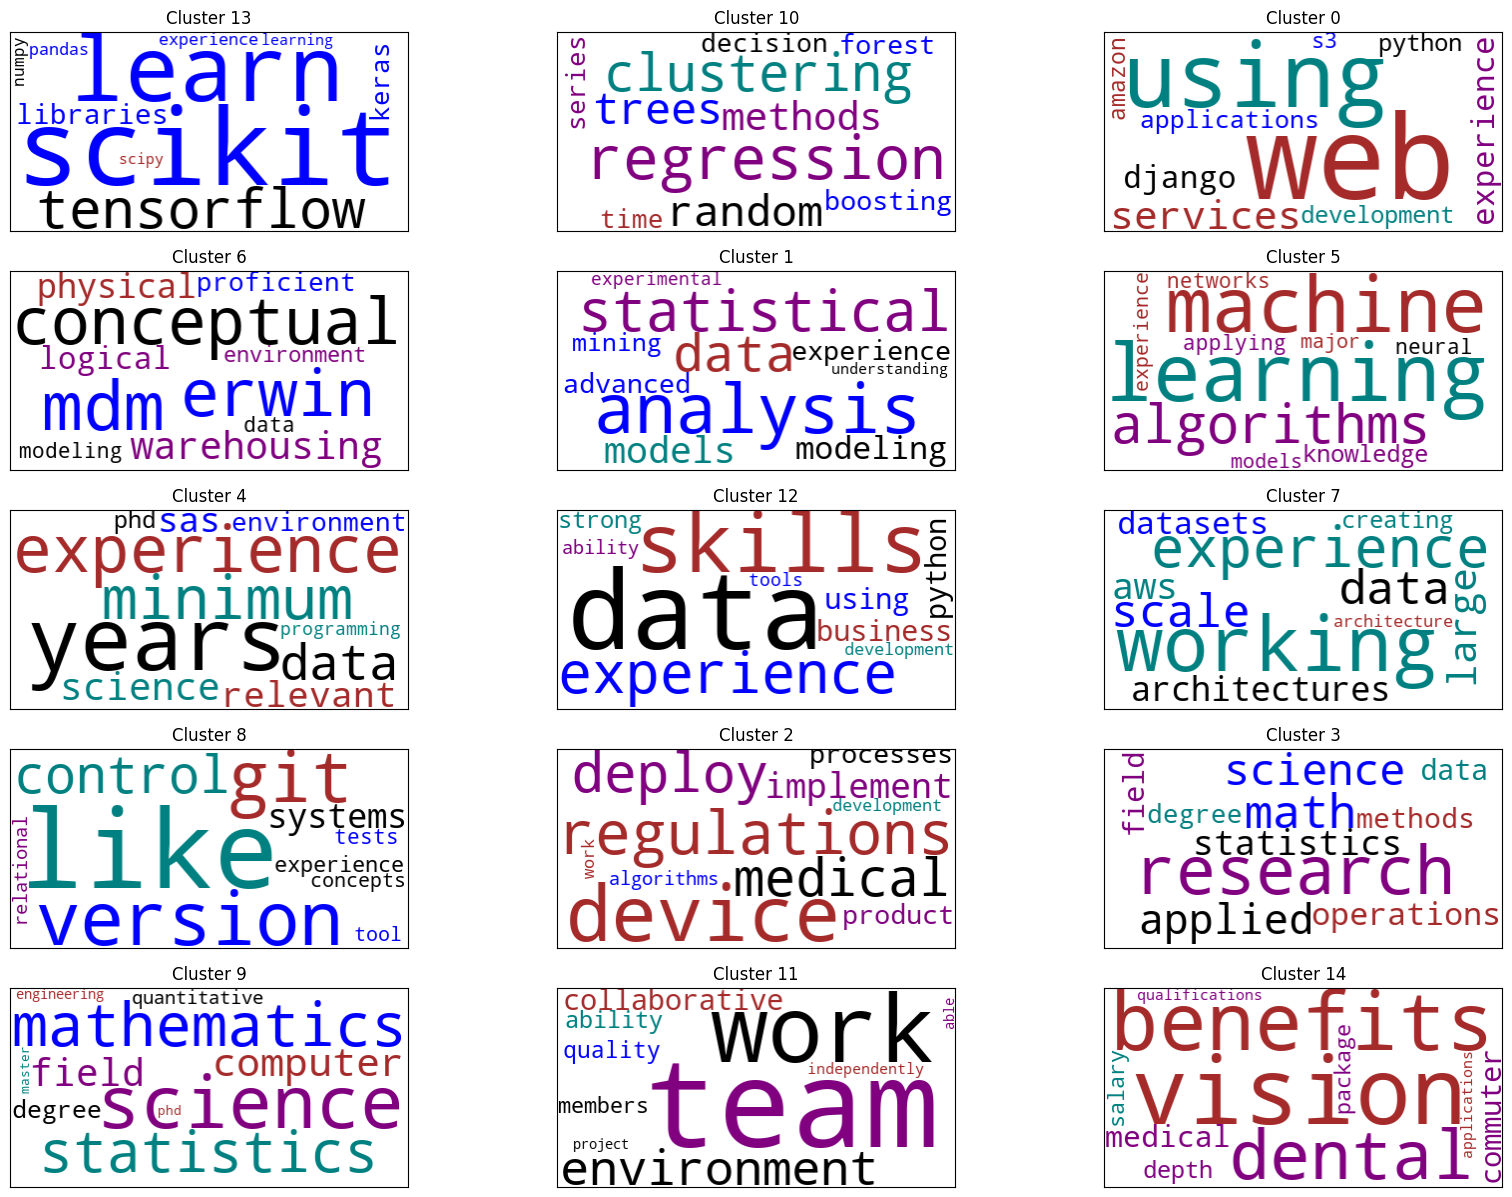

In [41]:
def sort_cluster_groups(cluster_groups):
    mean_similarities = [compute_mean_similarity(df_cluster)
                         for df_cluster in cluster_groups]
    
    sorted_indices = sorted(range(len(cluster_groups)),
                            key=lambda i: mean_similarities[i],
                            reverse=True)
    return [cluster_groups[i] for i in sorted_indices]

sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups)
plt.show()

Our hypothesis was right! The first 2 rows within the updated subplot clearly correspond to technical skills. F

### Investigating the Technical Skill Clusters
Lets turn our attention to the 6 technical-skill cluster within first 2 rows of subplot grid. Below, we’ll re-plot their associated word-clouds in a 2-row by 3-column grid. 

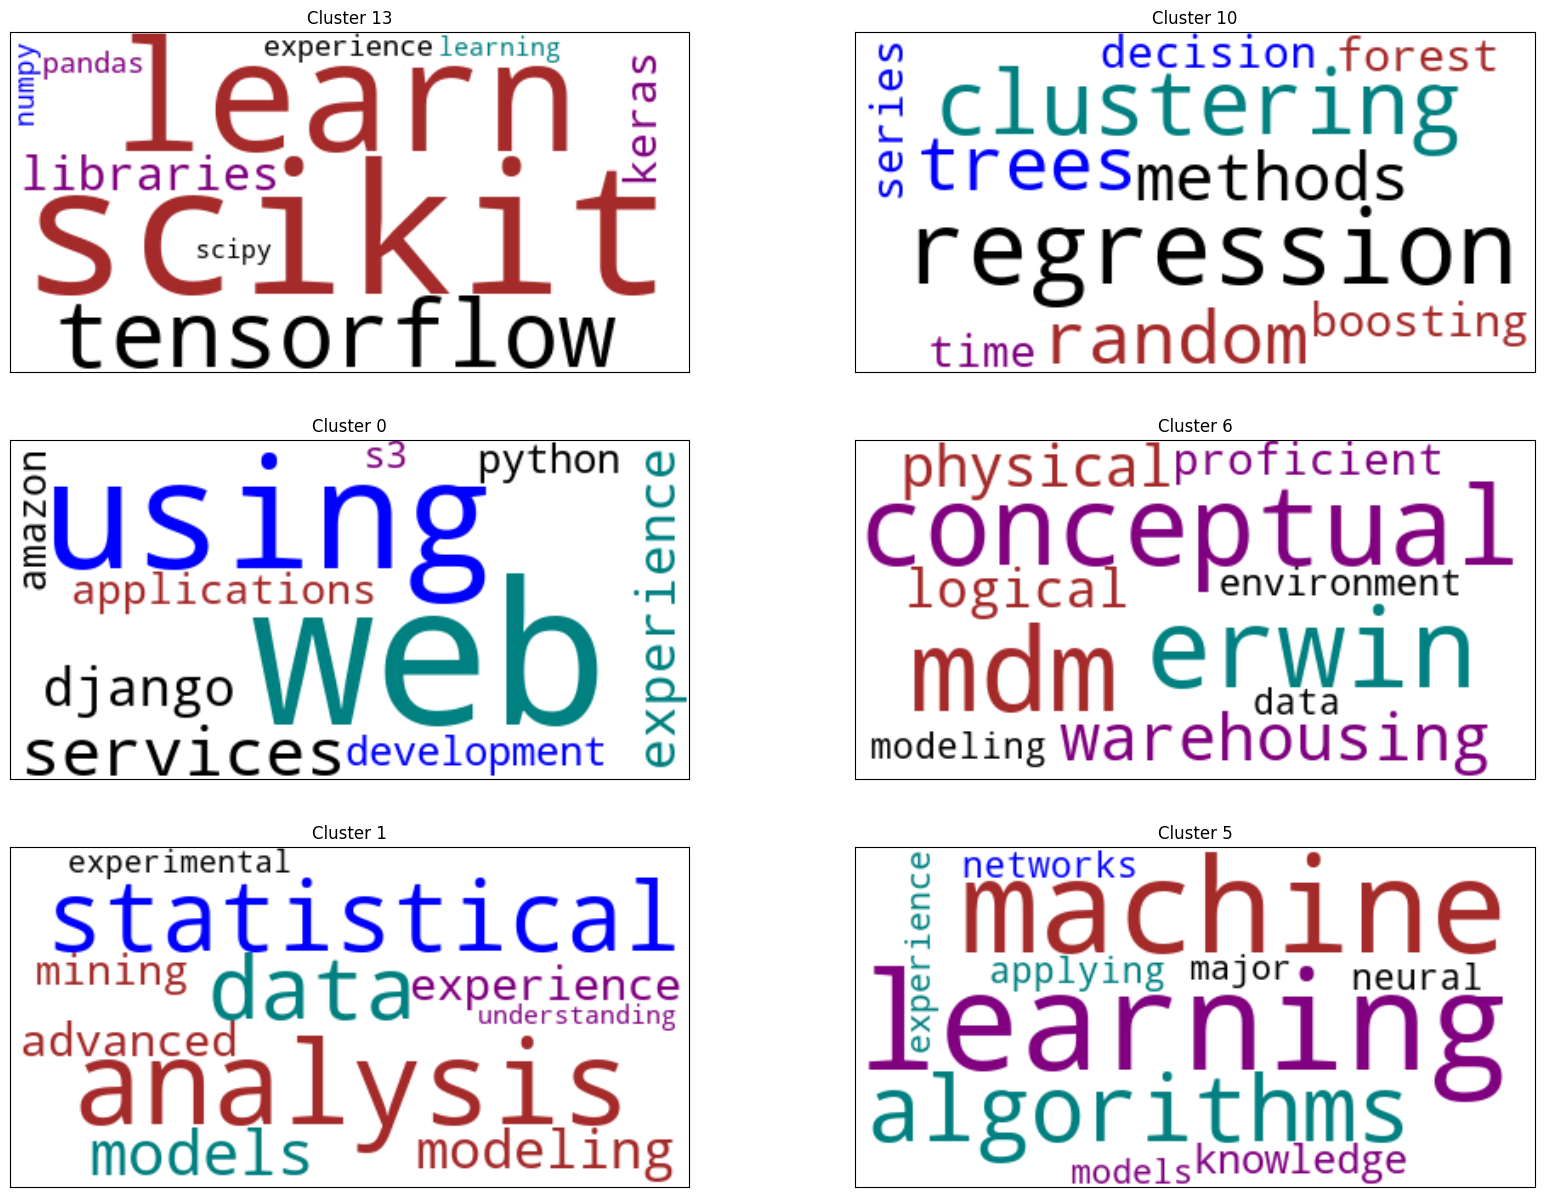

In [42]:
plot_wordcloud_grid(sorted_cluster_groups[:6], num_rows=3, num_columns=2)
plt.show()

The first 2 rows are insightful. We'll need to brush up on our machine learning skills. However, the final 2 technical-skill clusters appear are vague and uninformative. Below, we’ll sample bullets from these clusters (8 and 1) in order to confirm a lack of pattern.

**Printing sample bullets from Clusters 8 and 1**

In [43]:
np.random.seed(1)
for cluster_id in [8, 1]:
    print(f'\nCluster {cluster_id}:')
    print_cluster_sample(cluster_id)


Cluster 8:
Knowledge of word embedding concepts like word2vec and TF-IDF
Experience with statistical concepts like Hypothesis tests, probability distributions and statistical tests like ANOVA, F-statistic, Tuckey test etc
Experience in working with different operating systems like UNIX, LINUX, and WINDOWS
Experience in using various version control systems like Git, Github, CVS, and SVN
Experienced in relational databases like MS SQL server, MySQL, PostgreSQL, SQLite3, Cassandra, Oracle, and non-relational databases like MongoDB

Cluster 1:
Research and develop statistical learning models for data analysis
Strong background in statistical theory and application
Conducting ad-hoc analysis and innovation around data visualization
Use data visualization, statistical analysis, pattern recognition, and machine learning – along with domain knowledge and subject-specific models – to solve science, engineering, and commercial problems
Work with large, complex data sets. Solve difficult, non-r

We’ve finished our analysis of the technical-skill clusters. 4 of these clusters were relevant. 2 were not. Now, lets turn our attention to the remaining soft-skill clusters.

### Investing the Soft-Skill Clusters
We’ll start by visualizing the remaining 9 soft-skill clusters in a 3-row by 3-column grid.

**Plotting the remaining 9 soft-skill clusters**

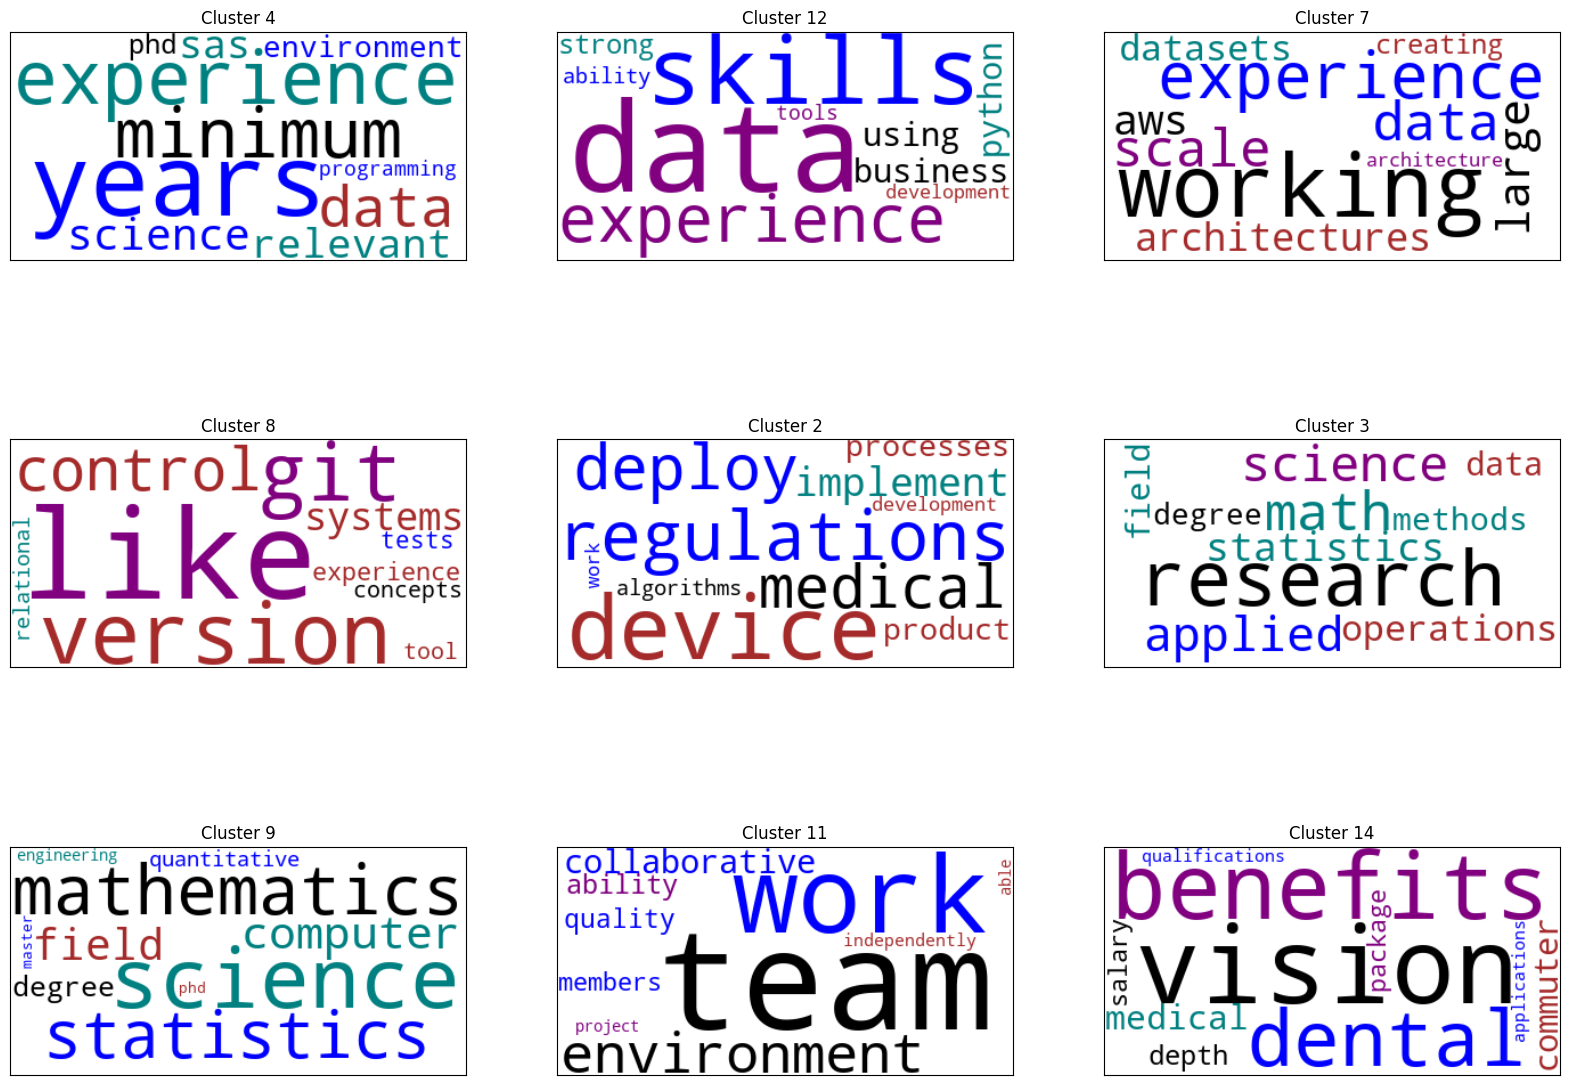

In [44]:
plot_wordcloud_grid(sorted_cluster_groups[6:], num_rows=3, num_columns=3)
plt.show()

The remaining clusters appear abmbiguous. Also, our soft-skill clusters do not represent true skills! For instance, Cluster 3 (row 0, column 0) consists of bullets requiring a minimal count of years working in industry. Similarly, Cluster 6 (row 2, column 1) represents educational constraints; requiring a quantitative degree to land an interview. 

**Printing sample bullets from Clusters 6 and 3**

In [45]:
np.random.seed(1)
for cluster_id in [6, 3]:
    print(f'\nCluster {cluster_id}:')
    print_cluster_sample(cluster_id)


Cluster 6:


ValueError: Cannot take a larger sample than population when 'replace=False'

However, one of our soft-skill clusters is very easy to interpret. Cluster 5 (row 0, column 1) focuses on interpersonal communication skills; both written and verbal. 


### Exploring Clusters at Alternative Values of K

Lets we’ll regenerate the clusters using alternative values of K. We’ll begin by setting K to 25, and plotting the results in a 5-row by 5-column grid. The subplots will be sorted based on cluster similarity to our resume. 

**Visualizing 25 sorted clusters**

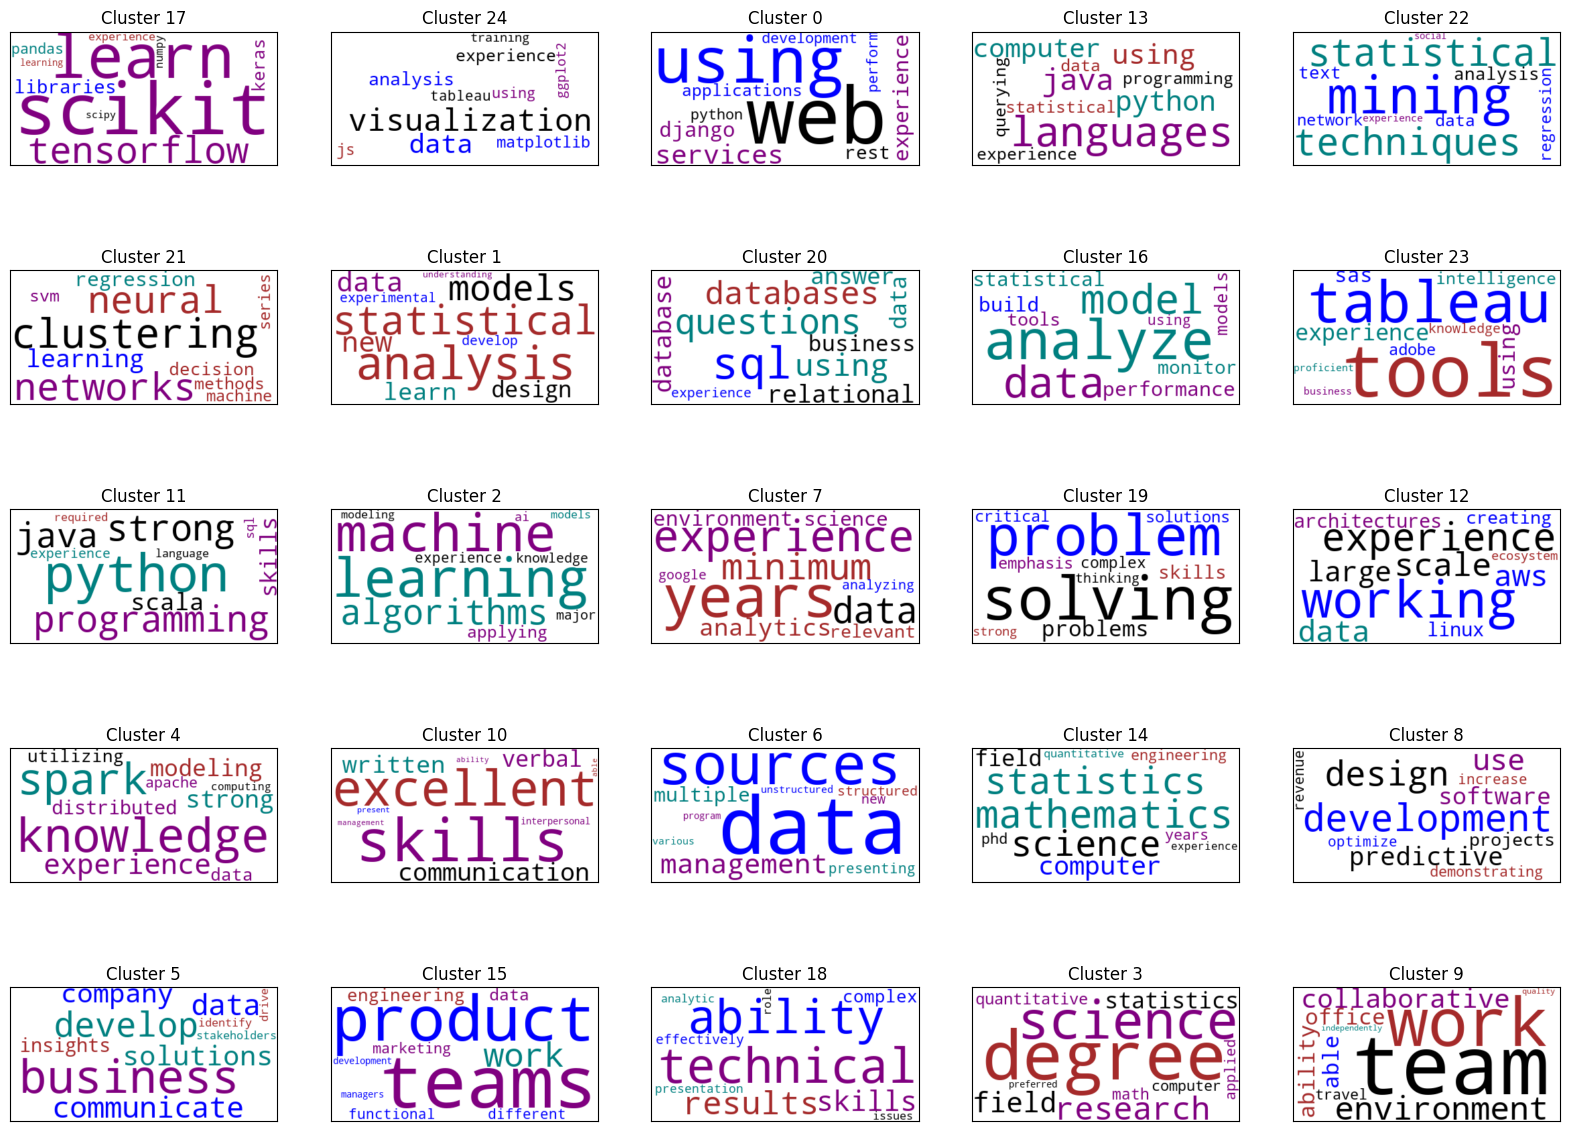

In [46]:
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=25)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=5, num_columns=5)
plt.show()

Raising K from 15 to 25 has retained all previously-observed insightful clusters. Also, the parameter change has introduced several new interesting clusters (Including Cluster 2: Non-Python Visualization tools and Cluster 23; Databases) Will the stability of these clusters persist if we shift K to an intermediate value of 20? Lets find out.

**Visualizing 20 sorted clusters**

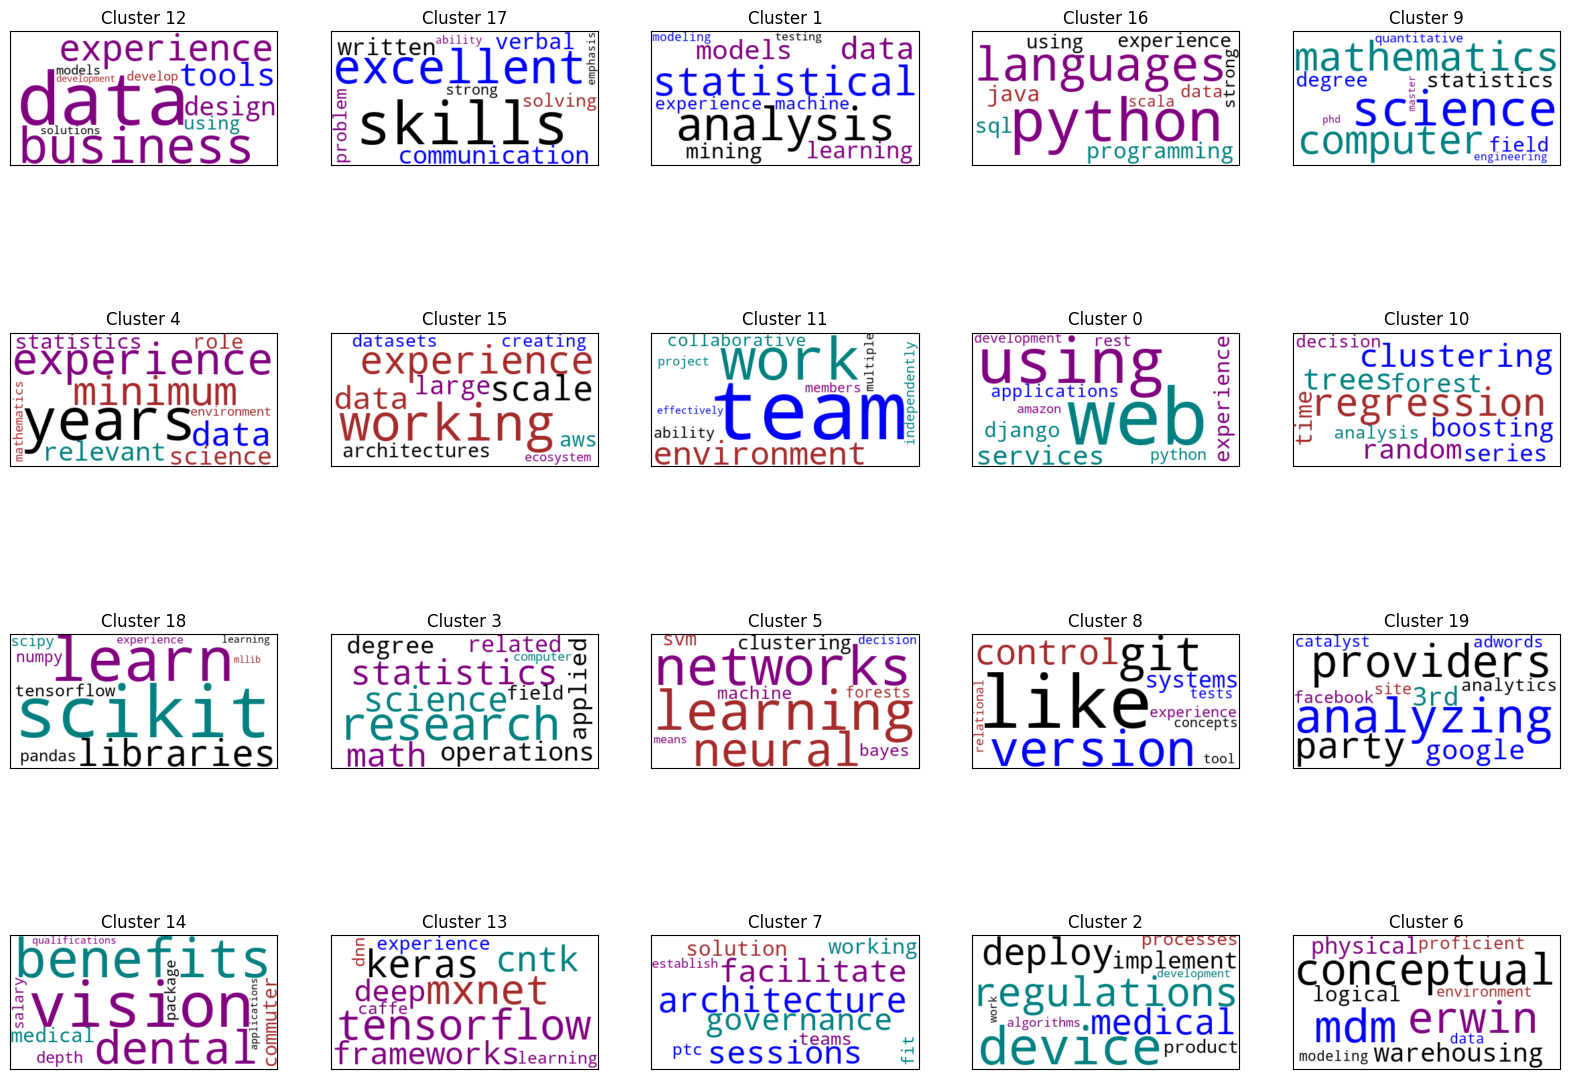

In [48]:
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=20)
sorted_cluster_groups = sorted(cluster_groups, key=lambda group: len(group), reverse=True)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=4, num_columns=5)
plt.show()

Most of our observed insightful clusters remain at `k=20`. However, the statistical analysis cluster observed at K-values of 15 and 25 is currently missing. If we cluster over just a single value of K, we risk missing out on useful insights. Thus, it’s preferable to visualize results over a range of K-values during text analysis. With this in mind, lets see what happens when we drop K to 10.

**Visualizing 10 sorted clusters**

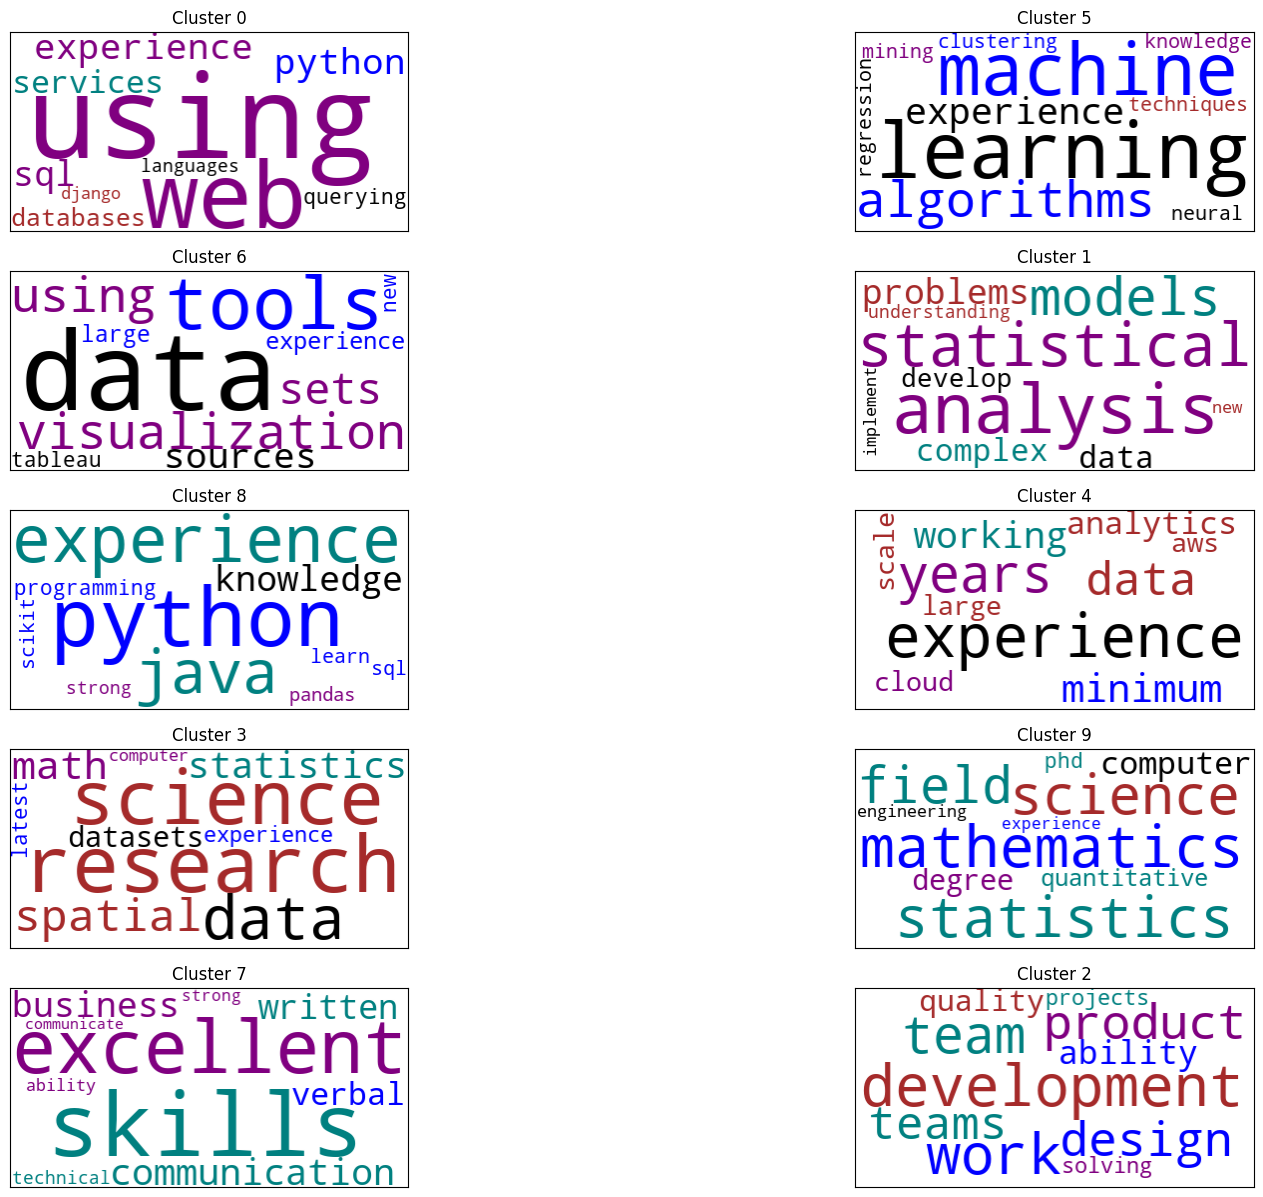

In [49]:
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=10)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=5, num_columns=2)
plt.show()

The 10 visualized clusters are quite limited. Nonetheless, 4 of the 10 clusters contain the critical skills we’ve previously observed. These include Python programming (row 0, column 0), machine learning (row 0, column 1), and communication skills (row 2, column 1). Also, the statistical analysis cluster has reappered (row 1, column 0).
Surprisingly, some of our skill-clusters are quite versatile. 

So far, our observations have been limited to the 60 most relevant job postings. What will happen if we extand our analysis to the top 700 postings?  We’ll now find out.

### Analyzing the 700 Most-Relevant Postings

We’ll start by preparing `sorted_df_jobs[:700].Bullets` for clustering.

**`Preparing sorted_df_jobs[:700]` for clustering analysis**

In [50]:
np.random.seed(0)
total_bullets_700 = set()
for bullets in sorted_df_jobs[:700].Bullets:
    total_bullets_700.update([bullet.strip()
                              for bullet in bullets])

total_bullets_700 = sorted(total_bullets_700)
vectorizer_700 = TfidfVectorizer(stop_words='english')
tfidf_matrix_700 = vectorizer_700.fit_transform(total_bullets_700)
shrunk_norm_matrix_700 = shrink_matrix(tfidf_matrix_700)
print(f"We've vectorized {shrunk_norm_matrix_700.shape[0]} bullets")

We've vectorized 10131 bullets


We’ve vectorized 10,194 bullet-points. Now, we’ll generate an Elbow plot across the vectorized results. Based on previous observations, we don’t expect the Elbow plot to be particularly informative. 

**Plotting an elbow curve for 10,194 bullets**

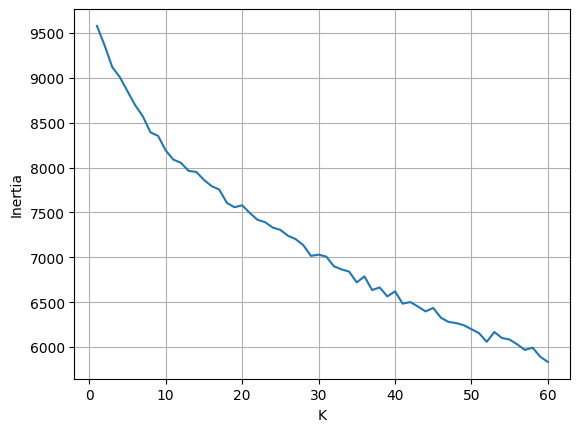

In [51]:
np.random.seed(0)
generate_elbow_plot(shrunk_norm_matrix_700)

As expected, the precise location of the elbow is not clear within the plot. The elbow is spread out between a K of 10 and 25. We’ll deal with ambiguity, by arbitrarily setting K to 20.

**WARNING: As we discussed in Section Fifteen, the K-means outputs could vary across computers for large matrices containing 10,000-by-100 elements. Thus, your local clustering results might differ from the output seen below. Nonetheless, you should be able to draw similar conclusions to the ones presented in this book.**

**Visualizing 20 sorted clusters for 10,194 bullets**

In [57]:
np.random.seed(0)
cluster_groups_700 = compute_cluster_groups(shrunk_norm_matrix_700, k=20)
bullet_cosine_similarities = compute_bullet_similarity(total_bullets_700)
sorted_cluster_groups_700 = sort_cluster_groups(cluster_groups_700)
plot_wordcloud_grid(sorted_cluster_groups_700, num_rows=4, num_columns=5,vectorizer=vectorizer_700, tfidf_matrix=tfidf_matrix_700)

ValueError: All arrays must be of the same length

Our clustering output looks very similar to what we’ve seen before. The key insightful clusters we’ve observed at 60 postings still remain.

# CONCLUSION:

### In this project, we focused on clustering and visualizing job bullet points using machine learning and natural language processing techniques. The idea was to transform a large set of job bullet points into meaningful clusters and then visualize them in an easily interpretable format.

### The goal of this project was to apply machine learning techniques, specifically clustering, to a real-world problem in the job market. By clustering job bullets, we were able to group similar job descriptions together and identify trends and patterns that can be valuable for job seekers, employers, or recruitment platforms.

### Through this approach, we demonstrated how unsupervised learning can be effectively used to explore and analyze unstructured text data, making it easier to identify insights and trends that might otherwise go unnoticed in large datasets.